# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for random $k$-regular graphs with $k=8$.

Compare the steady-state magnetization with its equilibrium value.

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings;

In [2]:
include("../../telegram/notifications.jl");

In [3]:
T = 25         # final time
k = 8          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.2
h = 0.0;

In [4]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [ ]:
matrix_sizes = [5, 10, 25]
maxiters = fill(50, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-5
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 34    Time: 0:16:36
  Δ:      8.475833418897238e-6


In [ ]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [ ]:
spin(x, i) = 3-2x
m = only(means(spin, bp));

In [30]:
m_eq, r_eq = equilibrium_observables(RandomRegular(k), J; β, h);

In [ ]:
err = abs(m[end]-m_eq)/abs(m_eq)

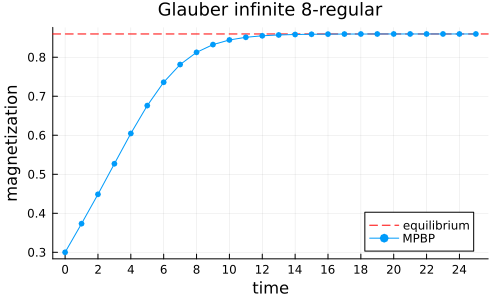

In [22]:
blue = theme_palette(:auto)[1]
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium")
pl = plot!(pl, 0:T, m, m=:o, xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
    legend=:bottomright, msc=:auto, c=blue)


# ylims = m_eq .+ 1e-3 .* (-1,1)
# plot!(pl, xticks=14:2:T, ylims=ylims, xlims=(14,T),
#     inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2#=, yticks=LinRange(ylims...,3)=#)
# plot!(pl[2], 0:T, m, m=:o, ylabel="", label="", ms=2, widen=true)
# hline!(pl[2], [m_eq], c=:red, ls=:dash, lw=1, label="")

In [ ]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, us = 0:floor(Int, T/5):T, kw...)
    step = skip_even ? 2 : 1
    cg = cgrad(:matter, length(us)+1, categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{t+\Delta t}\rangle-" * 
        L"\langle x_{i}^t\rangle\langle x_{i}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

c = only(autocovariances(bp))
ci = map(x -> x > 1e-16 ? x : NaN, c)
plot_autocovs(ci; us=0:4:T, skip_even=true, yaxis=:log10, st=:line)

In [ ]:
pb = pair_beliefs_as_mpem(bp)[1][1]
tv = twovar_marginals(pb);

In [36]:
r_bp = zeros(T)

ProgressMeter.@showprogress for t in 1:T
    tvt = tv[t,t+1]
    joint1 = dropdims(sum(tvt; dims=(2,3)); dims=(2,3))
    joint2 = dropdims(sum(tvt; dims=(1,4)); dims=(1,4))
#     @assert joint1 ≈ joint2
    r_bp[t] = expectation(spin, joint1)
end

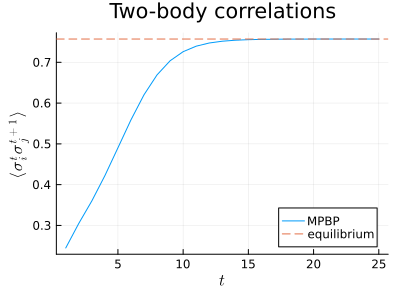

In [37]:
pl_c = plot(; title="Two-body correlations", xlabel=L"t", 
    ylabel=L"\langle \sigma_i^t \sigma_j^{t+1} \rangle")
plot!(pl_c, r_bp, label="MPBP")
hline!(pl_c, [r_eq], ls=:dash, label="equilibrium", size=(400,300))

### Compare with Monte Carlo on finite graphs

In [ ]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [ ]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

In [ ]:
import StatsBase, UnPack
function pair_marginals_ttp1(sms::SoftMarginSampler; showprogress::Bool=true) 
    UnPack.@unpack bp, X, w = sms
    g = bp.g
    T = length(bp.ϕ[1])-1; E = ne(g)
    marg = [[zeros(nstates(bp,i), nstates(bp,j)) for t in 1:T] for (i,j,id) in edges(g)]
    @assert all(>=(0), w)
    wv = StatsBase.weights(w)
    nsamples = length(X)
    prog = ProgressMeter.Progress(E, desc="Marginals from Soft Margin"; dt=showprogress ? 0.1 : Inf)
    x = zeros(Int, length(X))

    for (i,j,id) in edges(g)
        linear = LinearIndices((1:nstates(bp,i), 1:nstates(bp,j)))
        for t in 1:T
            x .= [linear[xx[i, t],xx[j,t+1]] for xx in X]
            mijt_avg_linear = StatsBase.proportions(x, nstates(bp,i)*nstates(bp,j), wv)
            mijt_avg = reshape(mijt_avg_linear, linear.indices...)
            # avoid numerical errors yielding probabilities > 1
            marg[id][t] .= map(x -> x≥1 ? 1 : x, mijt_avg)
        end
        ProgressMeter.next!(prog)
    end

   return marg
end

In [ ]:
marg_alternate = pair_marginals_ttp1(sms);

In [34]:
r_mc = expectation.(spin, mean(marg_alternate));

In [ ]:
blue = theme_palette(:auto)[1]
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium")
plot!(pl, 0:T, sample(m_mc, 10^2), label=permutedims(["samples"; fill("", 10^2-1)]), c=:gray, la=0.1)
plot!(pl, 0:T, mean(m_mc), label="sample mean", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)
pl = plot!(pl, 0:T, m, xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
    legend=:bottomright, msc=:auto, c=blue, lw=2)

ylims = m_eq .+ 2e-3 .* (-1,1)
plot!(pl, xticks=14:2:T, ylims=ylims, xlims=(14,T),
    inset=(1, bbox(0.5, 0.23, 0.4, 0.3)), subplot=2#=, yticks=LinRange(ylims...,3)=#)
hline!(pl[2], [m_eq], c=:red, ls=:dash, lw=1, label="")
plot!(pl[2], 0:T, mean(m_mc), c=:black, m=:diamond, ms=3, msc=:auto, label="", st=:scatter)
plot!(pl[2], 0:T, m, ylabel="", label="", ms=3, msc=:auto, widen=true, c=blue, lw=2)


plot!(pl, size=(500, 400))

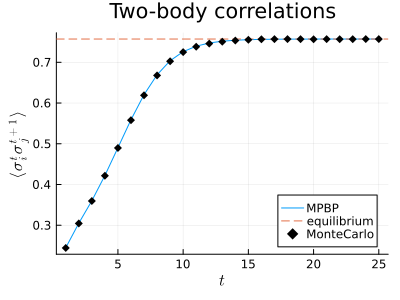

In [35]:
scatter!(deepcopy(pl_c), r_mc, m=:diamond, c=:black, label="MonteCarlo")

In [ ]:
@telegram "glauber infinite 8rrg"

In [38]:
jldsave("plot_data/glauber_infinite8RRG_smallbeta.jld2"; J, T, k, m_mc, m, m_eq, c, r_bp, r_mc, r_eq);